In [28]:
# input 이미지를 5분할하는 함수
def image_crop(file, image_width, image_height, cropped_width, cropped_height):
    cropped_images = []
    x = 0
    x_center = image_width // 2
    y_center = image_height // 2
    
    while x < image_width:
        y = 0
        while y < image_height:
            cropped_image = file[x : x + cropped_width, y : y + cropped_height]
            cropped_images.append(cropped_image)
            y += cropped_height
        x += cropped_width
    
    center_image = file[x_center - cropped_width // 2 : x_center + cropped_width // 2,
                       y_center - cropped_height // 2 : y_center + cropped_height // 2]
    
    cropped_images.append(center_image)
    
    return cropped_images

In [29]:
# 이미지를 조작하고 다룰 수 있게 처리해주는 함수
def data_generator(file, image_width, image_height):
    img_bgr = cv2.imread(file, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_rgb, (image_width, image_height))

    return img

In [30]:
import cv2
import os, glob, numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

img_dir = './binary_cnn_majority/test'
categories = ['ad', 'non_ad']

image_width = 120 # 사이즈 수정
image_height = 120

X = [] # 5분할 한 input 이미지
y = [] # input의 실제 분류 값 * 5
X_original = [] # input 이미지
y_original = [] # input의 실제 분류 값
index = []
files = []
filenames = []

n = 1
df = pd.DataFrame(index=['img_num'], columns=['y', 'pred', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'category'])
# y는 실제 분류 값, pred는 모델이 예측한 값

for i, category in enumerate(categories):
    img_detail = img_dir + '/' + category

    files.append(glob.glob(img_detail + "/*.jpg"))
    index.append(i)

In [31]:
for file, i in zip(files, index):
    for f in file:
        try:
            img = data_generator(f, image_width, image_height)
        
            original_data = np.asarray(img)
            X_original.append(original_data)
            y_original.append(i)

            df.loc[n, 'y'] = i
            n += 1

            cropped_images = image_crop(img, image_width, image_height, image_width // 2, image_height // 2)

            for cropped_image in cropped_images:
                data = np.asarray(cropped_image)

                head, tail = os.path.split(f)
                filenames.append(tail)

                X.append(data)
                y.append(i)
                
        except Exception as e:
            print(i,'번째에서 에러')

X = np.array(X)
y = np.array(y)
X_original = np.array(X_original)
y_original = np.array(y_original)

X = X.astype('float32') / 255

print(len(X), len(y))
print(len(X_original), len(y_original))

"""인자 바꾸기"""

print(df)

3480 3480
696 696
           y pred  X_0  X_1  X_2  X_3  X_4 category
img_num  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN
1          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
2          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
3          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
4          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
...      ...  ...  ...  ...  ...  ...  ...      ...
692        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
693        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
694        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
695        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
696        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN

[697 rows x 8 columns]


In [32]:
def print_scores(X, y, prediction):
    print('confusion matrix 결과')
    print(confusion_matrix(y, prediction, labels=[0, 1])) # 0: 광고, 1: 비광고

    print('precision 개별값')
    print(list(map('{:2.2f}%'.format, precision_score(y, prediction, average=None) * 100))) # precision 개별 값
    print('recall 개별값')
    print(list(map('{:2.2f}%'.format, recall_score(y, prediction, average=None) * 100)))

    
    print('f1 점수')
    print('{:2.2f}%'.format(f1_score(y, prediction, average='macro') * 100))

    print('precision 평균값')
    print('{:2.2f}%'.format(precision_score(y, prediction, average='macro') * 100)) # precision 평균 값
    
    print('recall 평균값')
    print('{:2.2f}%'.format(recall_score(y, prediction, average='macro') * 100))

In [33]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


model_evaluate = []
f1 = []
precision = []
recall = []


model = load_model('./binary_cnn_majority/model/size/binary_model_saved_i120.h5') # 모델 경로 수정

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) # 소수점 3자리까지 표기

prediction_original = []    
count = []

n = 1

# print(prediction)
# print(prediction.shape)

In [34]:
for p in prediction:
    is_ad = 0
    not_ad = 0
    amax = []

    count.append(p)
    
    if(len(count) == 1):
        df.loc[n, 'X_0'] = p
        continue

    elif(len(count) == 2):
        df.loc[n, 'X_1'] = p
        continue
        
    elif(len(count) == 3):
        df.loc[n, 'X_2'] = p
        continue    
        
    elif(len(count) == 4):
        df.loc[n, 'X_3'] = p
        continue
        
    elif len(count) == 5:
        df.loc[n, 'X_4'] = p
        
        for c in count:
            amax.append(c.round())
            if c.round() == 0:
                is_ad += 1
            elif c.round() == 1:
                not_ad += 1

        if is_ad > not_ad:
            prediction_original.append(0)
    
            df.loc[n, 'pred'] = 0
            n += 1
            
        else:
            prediction_original.append(1)
            
            df.loc[n, 'pred'] = 1
            n += 1

        count = []


print('투표 결과')
print(len(y_original), len(prediction_original))
print_scores(X_original, y_original, prediction_original)
precision.append(precision_score(y_original, prediction_original, average='macro') * 100)
recall.append(recall_score(y_original, prediction_original, average='macro') * 100)
f1.append(f1_score(y_original, prediction_original, average='macro') * 100)


투표 결과
696 696
confusion matrix 결과
[[300  68]
 [ 35 293]]
precision 개별값
['89.55%', '81.16%']
recall 개별값
['81.52%', '89.33%']
f1 점수
85.20%
precision 평균값
85.36%
recall 평균값
85.43%


In [29]:
df.to_csv('./binary_cnn_majority/csv/test_prediction_i120.csv', sep=',', na_rep='NaN')

------

In [38]:
dataFrame = pd.read_csv('./binary_cnn_majority/csv/test_prediction_i120.csv')
dataFrame.head()

,Unnamed: 0,y,pred,X_0,X_1,X_2,X_3,X_4,category
0,img_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.003],lotto_N
2,2,0.0,0.0,[0.201],[0.455],[0.127],[0.033],[0.024],picture
3,3,0.0,0.0,[0.007],[0.000],[0.097],[0.000],[0.000],part_of_human
4,4,0.0,0.0,[0.000],[0.158],[0.000],[0.165],[0.000],human


In [39]:
dataFrame.rename(columns={'Unnamed: 0' : 'img_num'}, inplace=True)
dataFrame.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category
0,img_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.003],lotto_N
2,2,0.0,0.0,[0.201],[0.455],[0.127],[0.033],[0.024],picture
3,3,0.0,0.0,[0.007],[0.000],[0.097],[0.000],[0.000],part_of_human
4,4,0.0,0.0,[0.000],[0.158],[0.000],[0.165],[0.000],human


In [40]:
dataFrame.drop(0, axis=0, inplace=True)
dataFrame.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category
1,1,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.003],lotto_N
2,2,0.0,0.0,[0.201],[0.455],[0.127],[0.033],[0.024],picture
3,3,0.0,0.0,[0.007],[0.000],[0.097],[0.000],[0.000],part_of_human
4,4,0.0,0.0,[0.000],[0.158],[0.000],[0.165],[0.000],human
5,5,0.0,0.0,[0.683],[0.299],[0.249],[0.201],[0.670],graph


In [41]:
dataFrame['unmatch'] = dataFrame['pred'] - dataFrame['y']
dataFrame.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category,unmatch
1,1,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.003],lotto_N,0.0
2,2,0.0,0.0,[0.201],[0.455],[0.127],[0.033],[0.024],picture,0.0
3,3,0.0,0.0,[0.007],[0.000],[0.097],[0.000],[0.000],part_of_human,0.0
4,4,0.0,0.0,[0.000],[0.158],[0.000],[0.165],[0.000],human,0.0
5,5,0.0,0.0,[0.683],[0.299],[0.249],[0.201],[0.670],graph,0.0


In [42]:
dataFrame['unmatch'].value_counts()

 0.0    593
 1.0     68
-1.0     35
Name: unmatch, dtype: int64

In [43]:
dataFrame['category'].value_counts()

non_ad             328
picture             42
human               40
photoshop           39
part_of_human       36
bill                33
lotto_P             31
general_product     31
graph               30
microbe             29
lotto_N             29
coin                28
Name: category, dtype: int64

In [44]:
dataFrame['unmatch'].value_counts()

 0.0    593
 1.0     68
-1.0     35
Name: unmatch, dtype: int64

In [45]:
d = dataFrame.groupby('category')[['unmatch']].sum()

In [46]:
d

,unmatch
category,
bill,10.0
coin,7.0
general_product,8.0
graph,2.0
human,9.0
lotto_N,4.0
lotto_P,6.0
microbe,4.0
non_ad,-35.0


In [47]:
d['total'] = [33, 28, 31, 30, 40, 29, 31, 29, 328, 36, 39, 42] # 수정 필요

In [48]:
d.loc['non_ad', 'unmatch'] = 35.0 # 수정 필요
print(d)

                 unmatch  total
category                       
bill                10.0     33
coin                 7.0     28
general_product      8.0     31
graph                2.0     30
human                9.0     40
lotto_N              4.0     29
lotto_P              6.0     31
microbe              4.0     29
non_ad              35.0    328
part_of_human        8.0     36
photoshop            4.0     39
picture              6.0     42


In [49]:
d['ratio'] = 1 - (d['unmatch'] / d['total'])
print(d)

                 unmatch  total     ratio
category                                 
bill                10.0     33  0.696970
coin                 7.0     28  0.750000
general_product      8.0     31  0.741935
graph                2.0     30  0.933333
human                9.0     40  0.775000
lotto_N              4.0     29  0.862069
lotto_P              6.0     31  0.806452
microbe              4.0     29  0.862069
non_ad              35.0    328  0.893293
part_of_human        8.0     36  0.777778
photoshop            4.0     39  0.897436
picture              6.0     42  0.857143


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

<BarContainer object of 12 artists>

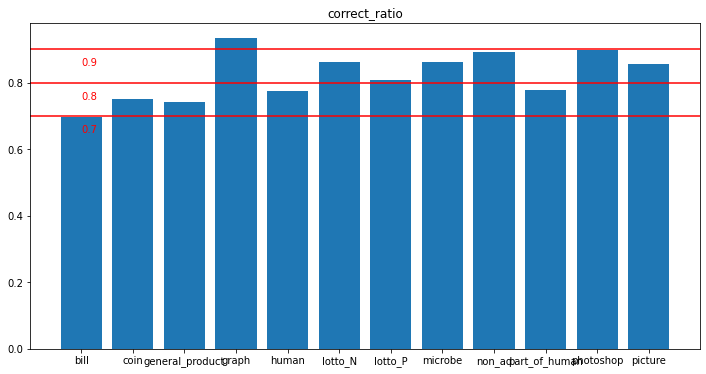

In [21]:
# 각 카테고리별 정확도(정답인 것의 수)
plt.figure(figsize=(12, 6))
plt.axhline(0.9, color='red')
plt.text(0.01, 0.85, '0.9', color='red')
plt.axhline(0.8, color='red')
plt.text(0.01, 0.75, '0.8', color='red')
plt.axhline(0.7, color='red')
plt.text(0.01, 0.65, '0.7', color='red')
plt.title('correct_ratio')
plt.bar(d.index, d['ratio'])

In [50]:
u = dataFrame.loc[dataFrame['y'] != dataFrame['pred']]

In [23]:
cnt = u['category'].value_counts()
print(cnt)

non_ad             35
bill               10
human               9
general_product     8
part_of_human       8
coin                7
lotto_P             6
picture             6
photoshop           4
microbe             4
lotto_N             4
graph               2
Name: category, dtype: int64


([<matplotlib.patches.Wedge at 0x1c7ce8b7760>,
 [Text(0.5305170031691713, 0.9636138798026945, 'non_ad'),
  Text(-0.840247746018027, 0.7099181116943175, 'bill'),
  Text(-1.0918234542062502, 0.13387137425578616, 'human'),
  Text(-1.0146552131628097, -0.4248232554857766, 'general_product'),
  Text(-0.6970218863461025, -0.8509761982303155, 'part_of_human'),
  Text(-0.24944360389918116, -1.0713439636614324, 'coin'),
  Text(0.18366606821550369, -1.084558331942666, 'lotto_P'),
  Text(0.5596566681731565, -0.9469870187966262, 'picture'),
  Text(0.8182071618965682, -0.735212241615415, 'photoshop'),
  Text(0.971592117913057, -0.5157603672338741, 'microbe'),
  Text(1.0674154041107797, -0.2657524319117716, 'lotto_N'),
  Text(1.0979539591287983, -0.06706044760809005, 'graph')],
 [Text(0.28937291081954797, 0.5256075708014697, '33.98%'),
  Text(-0.4583169523734692, 0.3872280609241731, '9.71%'),
  Text(-0.5955400659306818, 0.07302074959406517, '8.74%'),
  Text(-0.5534482980888052, -0.23172177571951447,

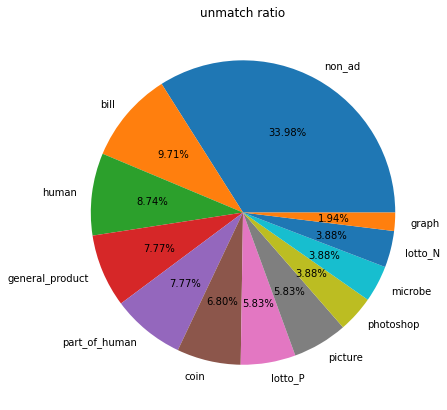

In [24]:
# 오답인 것들 중 각 카테고리의 비율
plt.figure(figsize=(7, 7))
plt.title('unmatch ratio')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%')

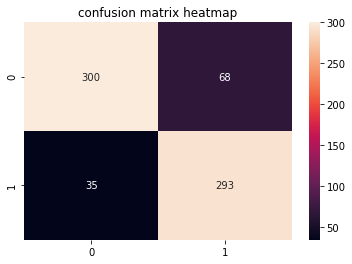

In [35]:
cm = confusion_matrix(y_original, prediction_original, labels=[0,1]) # 0: 광고, 1: 비광고

plt.title('confusion matrix heatmap')
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [52]:
dataFrame.to_csv('./binary_cnn_majority/csv/test_prediction_with_unmatch_i120.csv')